In [59]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pycountry
# Load student-level data (adjust path if needed)
stu = pd.read_sas("../data/oecd/STU_QQQ_SAS/CY08MSP_STU_QQQ.SAS7BDAT", format='sas7bdat', encoding='latin1')
# Map 3-letter country codes (CNT) to full country names (idempotent)
country_map = {c.alpha_3: c.name for c in pycountry.countries}
if 'CountryName' not in stu.columns:
    stu['CountryName'] = stu['CNT'].map(country_map)
# Preserve original CNT in a clearly named column so it's never overwritten
if 'CountryCode' not in stu.columns:
    stu['CountryCode'] = stu['CNT']
# A top-level list of country codes present in the data (useful downstream)
countrynames = sorted(stu['CountryCode'].dropna().unique().tolist())


/var/folders/b0/czsnk64s6wdcpxlyxxbmgxv80000gn/T/ipykernel_60326/76081110.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stu['CountryName'] = stu['CNT'].map(country_map)
/var/folders/b0/czsnk64s6wdcpxlyxxbmgxv80000gn/T/ipykernel_60326/76081110.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stu['CountryCode'] = stu['CNT']


In [51]:
# NOTE: mapping is performed in the top cell; this cell is intentionally left minimal
# It is safe to re-run and will not overwrite existing 'CountryName' column.
import pycountry
country_map = {c.alpha_3: c.name for c in pycountry.countries}
if 'CountryName' not in stu.columns:
    stu['CountryName'] = stu['CNT'].map(country_map)

In [61]:
ses_vars = ['ESCS', 'PAREDINT', 'HISEI']
subjects = ['MATH','READ','SCIE']
pv_vars = [f'PV{i}{subj}' for i in range(1,11) for subj in subjects]

# Basic country-level summary (group by CountryCode so downstream filters use codes)

summary = stu.groupby('CountryCode').apply(
    lambda x: pd.Series({
        'N_students': len(x),
        'ESCS_missing_pct': x['ESCS'].isna().mean() * 100,
        'PARED_missing_pct': x['PAREDINT'].isna().mean() * 100,
        'HISEI_missing_pct': x['HISEI'].isna().mean() * 100,
        'PV_valid_count': x[pv_vars].notna().sum().sum()
    })
).reset_index().rename(columns={'CountryCode':'Country'})

# Sort by sample size
summary = summary.sort_values('N_students', ascending=False)

# Add readable country name for display
summary['CountryName'] = summary['Country'].map(country_map)
# Sort by sample size
summary = summary.sort_values('N_students', ascending=False)

# Filter eligible countries (keep the country codes in the list)
eligible_countries = summary.loc[
    (summary['N_students'] >= 5000) &
    (summary['ESCS_missing_pct'] <= 10) &
    (summary['PARED_missing_pct'] <= 10) &
    (summary['HISEI_missing_pct'] <= 10),
    'Country'
].tolist()


/var/folders/b0/czsnk64s6wdcpxlyxxbmgxv80000gn/T/ipykernel_60326/407414065.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = stu.groupby('CountryCode').apply(


In [47]:
# List countries excluded by the eligibility criteria (show readable names)
excluded_countries = summary.loc[~summary['CountryName'].isin(eligible_countries), 'CountryName'].tolist()
print(excluded_countries)
# Show the summary rows for excluded countries
summary.loc[~summary['CountryName'].isin(eligible_countries)]

['United Arab Emirates', 'Canada', 'United Kingdom', 'Argentina', 'Brazil', 'Finland', 'Palestine, State of', 'Jordan', 'Qatar', 'Lithuania', 'Philippines', 'Mongolia', 'Saudi Arabia', 'France', 'El Salvador', 'Norway', 'North Macedonia', 'Georgia', 'Chile', 'Israel', 'Albania', 'Germany', 'Costa Rica', 'Bulgaria', 'Sweden', 'Poland', 'Hong Kong', 'Slovakia', 'Montenegro', 'Latvia', 'Netherlands', 'New Zealand', 'United States', 'Panama', 'Macao', 'Jamaica', 'Iceland', 'Malta']


,CountryName,N_students,ESCS_missing_pct,PARED_missing_pct,HISEI_missing_pct,PV_valid_count
70,United Arab Emirates,24600.0,5.658537,5.841463,15.292683,738000.0
9,Canada,23073.0,7.268236,7.632297,15.654661,692190.0
71,United Kingdom,12972.0,14.554425,17.607154,22.109158,389160.0
1,Argentina,12111.0,3.236727,3.352324,12.385435,363330.0
5,Brazil,10798.0,4.297092,5.010187,14.641600,323940.0
19,Finland,10239.0,3.008106,3.525735,10.557672,307170.0
51,"Palestine, State of",7905.0,2.593295,2.643896,14.611006,237150.0
34,Jordan,7799.0,2.077189,2.256700,13.501731,233970.0
58,Qatar,7676.0,6.513809,7.321522,18.199583,230280.0
38,Lithuania,7257.0,3.224473,4.740251,17.569243,217710.0


In [53]:
results = []

for country in eligible_countries:
    stu_ctry = stu[stu['CNT'] == country]
    
    for subj in subjects:
        for ses in ses_vars:
            pv_coefs, pv_ses = [], []
            
            for pv_num in range(1,11):
                pv_col = f'PV{pv_num}{subj}'  # e.g., PV1MATH
                df = stu_ctry[[pv_col, ses, 'W_FSTUWT']].dropna()
                
                if df.empty:
                    continue
                
                X = sm.add_constant(df[ses])
                y = df[pv_col]
                w = df['W_FSTUWT']
                
                model = sm.WLS(y, X, weights=w)
                res = model.fit()
                
                pv_coefs.append(res.params[ses])
                pv_ses.append(res.bse[ses])
            
            # Combine estimates using Rubin's rules
            m = len(pv_coefs)
            coef_mean = np.mean(pv_coefs)
            within_var = np.mean(np.square(pv_ses))
            between_var = np.var(pv_coefs, ddof=1)
            total_var = within_var + (1 + 1/m) * between_var
            total_se = np.sqrt(total_var)
            
            results.append({
                'Country': country,
                'Subject': subj,
                'SES': ses,
                'Coef': coef_mean,
                'SE': total_se
            })

results_df = pd.DataFrame(results)
results_df.head()

,Country,Subject,SES,Coef,SE
0,ESP,MATH,ESCS,32.325643,0.553436
1,ESP,MATH,PAREDINT,6.718253,0.189549
2,ESP,MATH,HISEI,1.092689,0.022805
3,ESP,READ,ESCS,30.542562,0.864474
4,ESP,READ,PAREDINT,6.694703,0.304785


In [64]:
results_df.to_csv("../output/pisa_ses_results.csv", index=False)

results_df = pd.read_csv("../output/pisa_ses_results.csv")


CountryName         Albania     Argentina        Brazil     Bulgaria  \
ESCS     count  5575.000000  11719.000000  10334.000000  5860.000000   
         mean     -0.743910     -0.671481     -0.975239    -0.270475   
         std       1.079404      1.145581      1.127870     1.043526   
         min      -5.238000     -5.488000     -5.108300    -6.074500   
         25%      -1.543150     -1.491850     -1.723400    -1.011750   
         50%      -0.756100     -0.675600     -0.947900    -0.179100   
         75%       0.109050      0.252350     -0.135950     0.569250   
         max       2.830000      2.478100      2.138600     5.254900   
PAREDINT count  5577.000000  11705.000000  10257.000000  5859.000000   
         mean     12.877353     13.156429     12.880959    13.900324   
         std       3.059097      3.243679      3.623956     2.551143   
         min       3.000000      3.000000      3.000000     3.000000   
         25%      12.000000     12.000000     12.000000    12.00

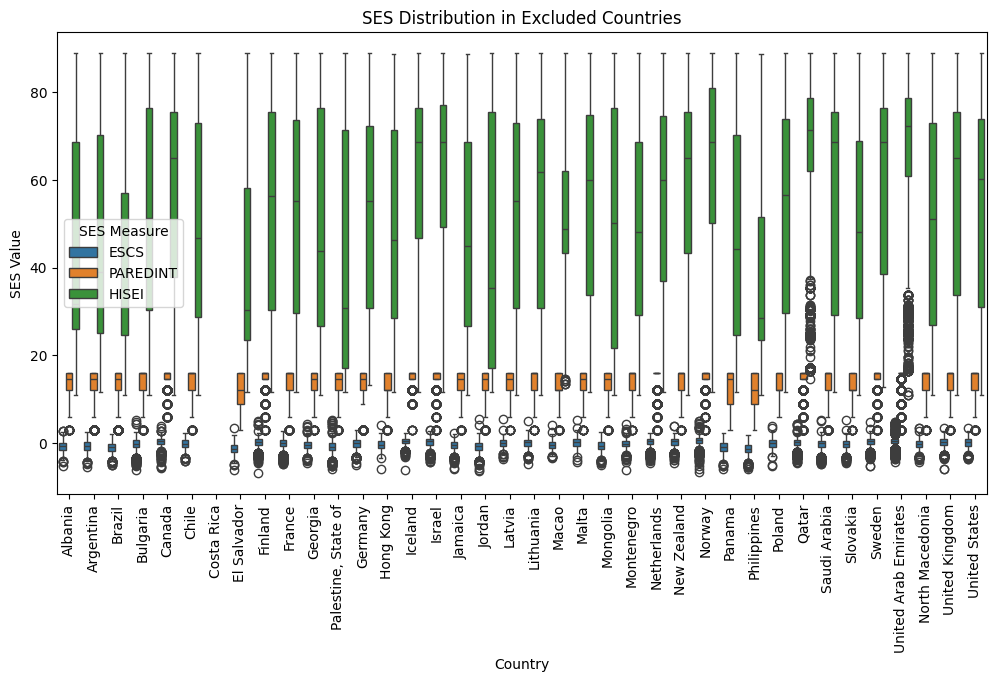

In [65]:
# Map CountryName for excluded countries
stu['CountryName'] = stu['CountryName'].fillna(stu['CNT'].map(country_map))

# Filter student-level data for excluded countries
excluded_stu = stu[stu['CountryName'].isin(excluded_countries)]

# Optional: quick descriptive summary
desc_excluded = excluded_stu.groupby('CountryName')[ses_vars].describe().transpose()
print(desc_excluded)

# Example: boxplot of SES distributions for excluded countries
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
melted = excluded_stu.melt(id_vars='CountryName', value_vars=ses_vars, 
                           var_name='SES', value_name='Value')
sns.boxplot(data=melted, x='CountryName', y='Value', hue='SES')
plt.xticks(rotation=90)
plt.title("SES Distribution in Excluded Countries")
plt.ylabel("SES Value")
plt.xlabel("Country")
plt.legend(title="SES Measure")
plt.show()

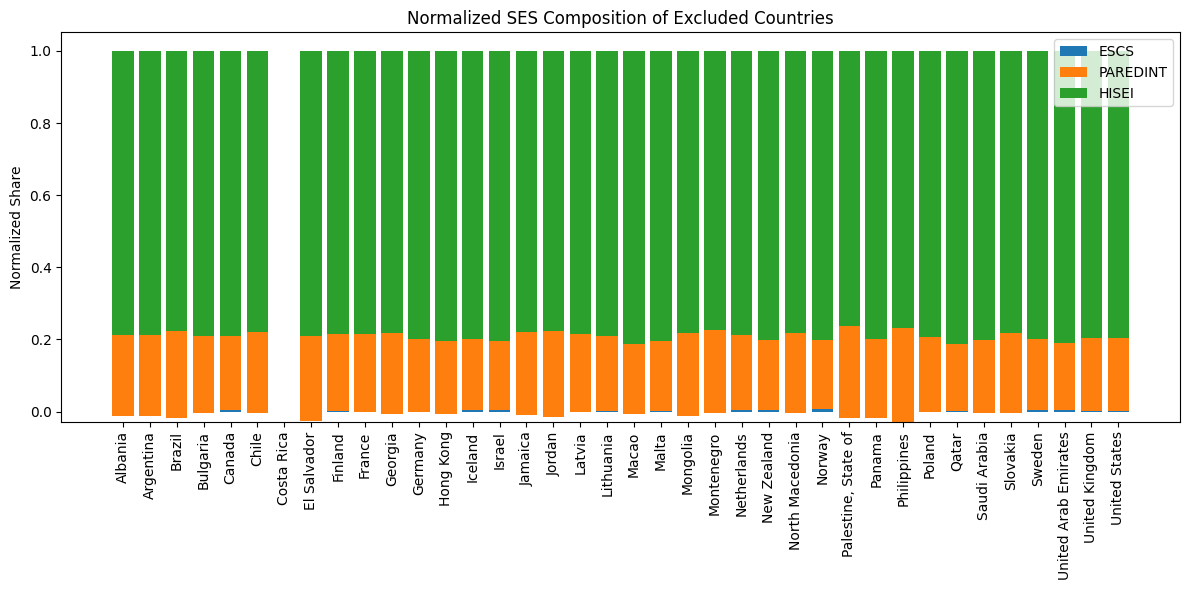

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

excluded_stu = stu[stu['CountryName'].isin(excluded_countries)]

means = excluded_stu.groupby('CountryName')[ses_vars].mean()
norm = means.div(means.sum(axis=1), axis=0)

long = norm.reset_index().melt(id_vars='CountryName', 
                               var_name='SES', value_name='Share')

countries = long['CountryName'].unique()
ses_list = long['SES'].unique()

fig, ax = plt.subplots(figsize=(12,6))
bottom = pd.Series([0]*len(countries), index=countries)

for ses in ses_list:
    vals = long[long['SES']==ses].set_index('CountryName')['Share']
    ax.bar(countries, vals, bottom=bottom.loc[countries], label=ses)
    bottom = bottom.add(vals, fill_value=0)

plt.xticks(rotation=90)
plt.ylabel('Normalized Share')
plt.title('Normalized SES Composition of Excluded Countries')
plt.legend()
plt.tight_layout()
plt.show()

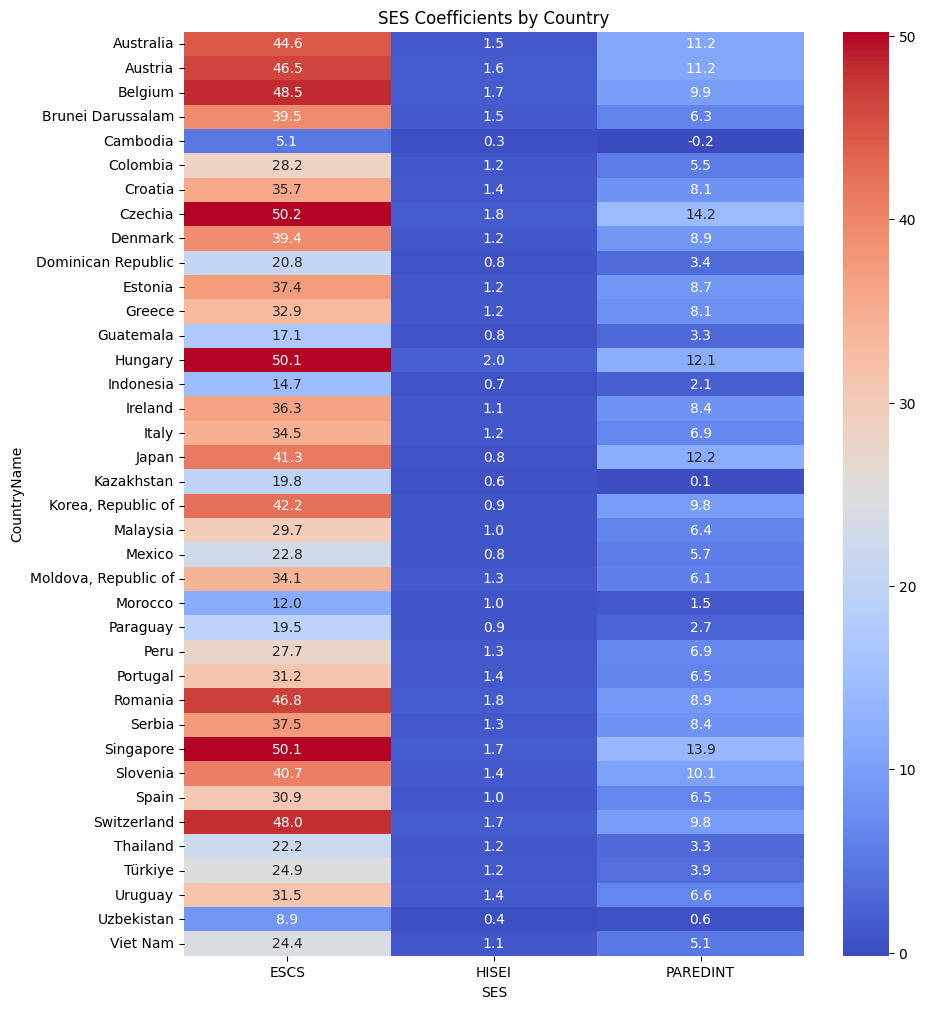

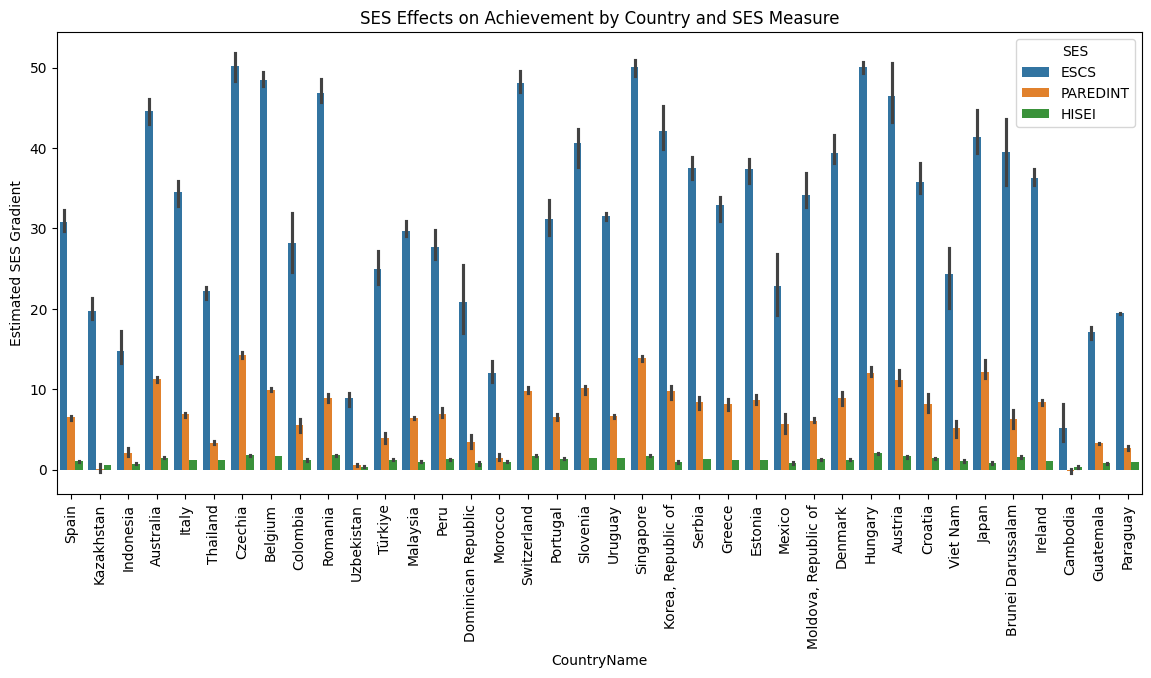

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

import pycountry
country_map = {c.alpha_3: c.name for c in pycountry.countries}
results_df['CountryName'] = results_df['Country'].map(country_map)

# Pivot results for plotting
pivot_df = results_df.pivot_table(
    index='CountryName', 
    columns='SES', 
    values='Coef'
).reset_index()

# Melt for seaborn
plot_df = pivot_df.melt(id_vars='CountryName', var_name='SES', value_name='Coef')

# Example: heatmap
# Correct pivot
heatmap_data = plot_df.pivot(index='CountryName', columns='SES', values='Coef')
plt.figure(figsize=(10,12))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('SES Coefficients by Country')
plt.show()

# Example: barplot by subject
plt.figure(figsize=(14,6))
sns.barplot(
    data=results_df,
    x='CountryName',
    y='Coef',
    hue='SES'
)
plt.xticks(rotation=90)
plt.ylabel('Estimated SES Gradient')
plt.title('SES Effects on Achievement by Country and SES Measure')
plt.show()

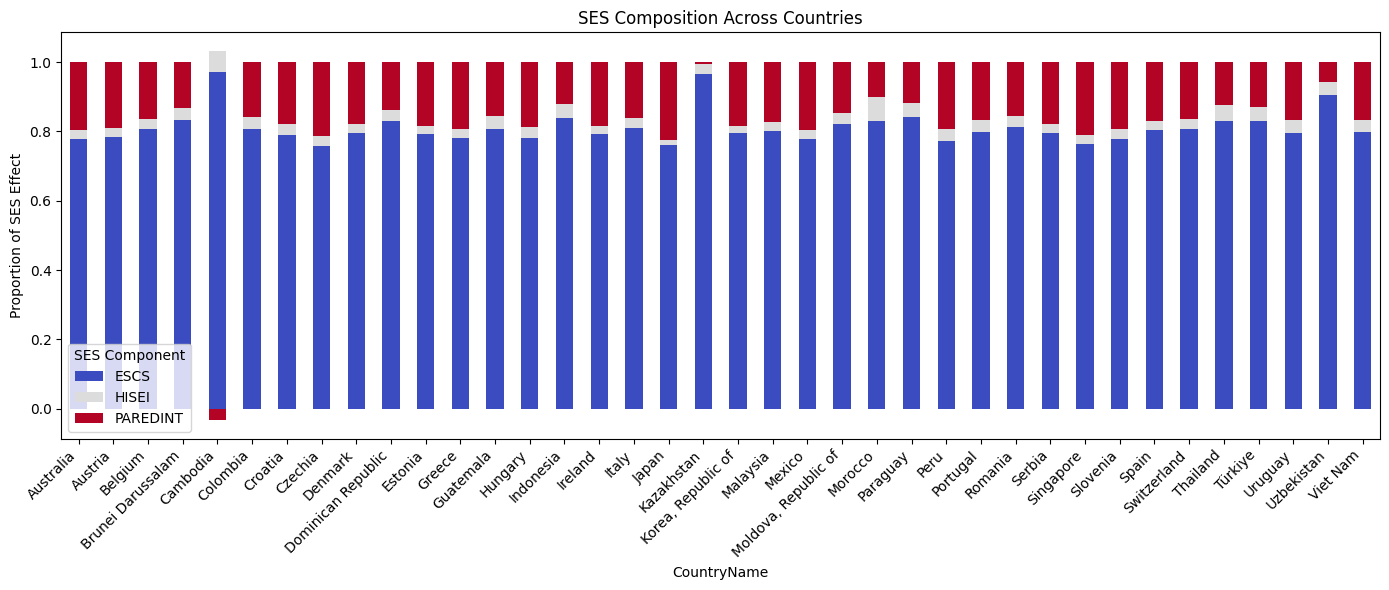

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import pycountry

# Map country codes
country_map = {c.alpha_3: c.name for c in pycountry.countries}
results_df['CountryName'] = results_df['Country'].map(country_map)

# Filter ESCS components only
ses_cols = ['ESCS','PAREDINT','HISEI']
pivot_df = results_df.pivot_table(index='CountryName', columns='SES', values='Coef', aggfunc='mean')

# Normalize contributions per country
pivot_df_norm = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot stacked bar
pivot_df_norm.plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.ylabel("Proportion of SES Effect")
plt.title("SES Composition Across Countries")
plt.xticks(rotation=45, ha='right')
plt.legend(title='SES Component')
plt.tight_layout()
plt.show()

<Axes: xlabel='CountryName'>

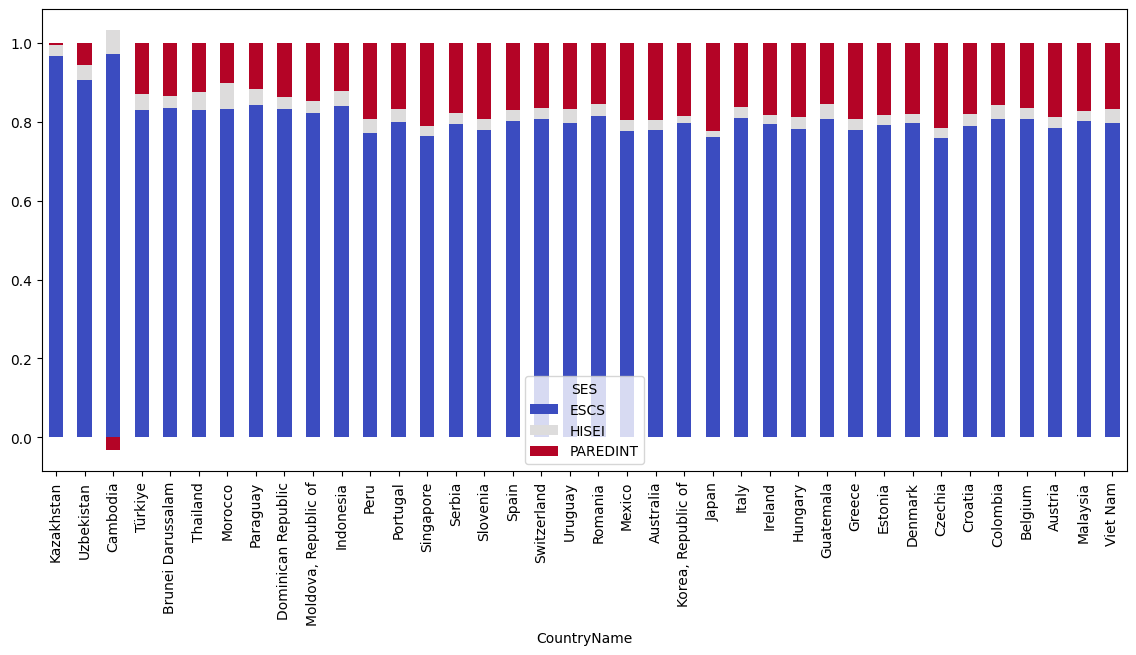

In [57]:
import seaborn as sns
import scipy.cluster.hierarchy as sch

# Cluster
linkage = sch.linkage(pivot_df_norm, method='ward')
cluster_idx = sch.fcluster(linkage, t=3, criterion='maxclust')  # optional: 3 clusters
pivot_df_norm['Cluster'] = cluster_idx
pivot_df_norm = pivot_df_norm.sort_values('Cluster')
pivot_df_norm.drop(columns='Cluster').plot(kind='bar', stacked=True, figsize=(14,6), colormap = 'coolwarm')